# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [3]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
using Statistics
using StatsBase

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]


1

## Simulate data

All SNPs have the same MAF

In [13]:
k = 0 # number of causal SNPs
maf = 0.3

qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    τtrue = 0.01,
    T = Float64,
    maf = maf,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit null model

In [21]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
        derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.


No errors detected by derivative checker.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:  

In [22]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, -0.5, 0.5]
qc_model.β = [1.0084080062401255, -0.5032114817029744, 0.4995534118086441]
qc_model.∇β = [6.625219252098802e-7, 6.865436435535277e-7, -1.656041806463726e-7]
θtrue = [0.1]
qc_model.θ = [0.09381595040390994]
qc_model.∇θ = [-8.218708632545813e-7]
qc_model.τ = [1.0]
qc_model.∇τ = [0.0]


## Score test GWAS

In [10]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 24.863348343711525
Qtime = 5.003755677004252
Rtime = 0.9684843550326847
 35.138363 seconds (488.49 M allocations: 34.853 GiB, 6.83% gc time, 5.55% compilation time)


1000-element Vector{Float64}:
 0.8963678979454119
 0.8730059475721652
 0.27776490475379534
 0.9879217368071667
 0.4551035962533694
 0.8278323577289538
 0.3388834995000992
 0.0012139867602387255
 0.8219744346485873
 0.19106664834718867
 0.6940606684549804
 0.4028622102529422
 0.26343750737964855
 ⋮
 0.14368145870756205
 0.626150921581082
 0.7357646380754397
 0.8253124391881149
 0.06937441280061031
 0.17582738674787593
 0.7840049505688851
 0.49748598515186127
 0.10705298755718713
 0.49813051814348486
 0.07167297445912846
 0.523782932671687

In [16]:
# Bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 27.70978494882905
Qtime = 4.728491793979356
Rtime = 1.2169664819484998
 37.071799 seconds (514.18 M allocations: 36.208 GiB, 7.92% gc time, 2.49% compilation time)


1000-element Vector{Float64}:
 0.24111253290901308
 0.949945797667916
 0.7552815131221867
 0.12428671507354219
 0.9550313387475392
 0.37009055137260183
 0.9206540699925326
 0.05841157642049383
 0.6254057180419972
 0.2022806031629963
 0.731331520532007
 0.38458549352792065
 0.05901182139076439
 ⋮
 0.4446078593294592
 0.7959088772831123
 0.2906119689673303
 0.4998466981064357
 0.45012390017886145
 0.20933795386912857
 0.939495770510204
 0.5213178108666833
 0.21877853402727923
 0.782672287554301
 0.16851804542087398
 0.500733508459739

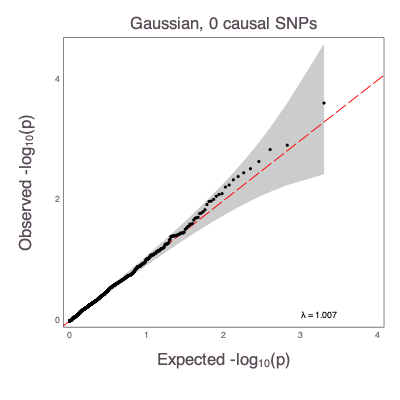

In [12]:
# gaussian
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs")
display("image/png", read("qqplot.png"))

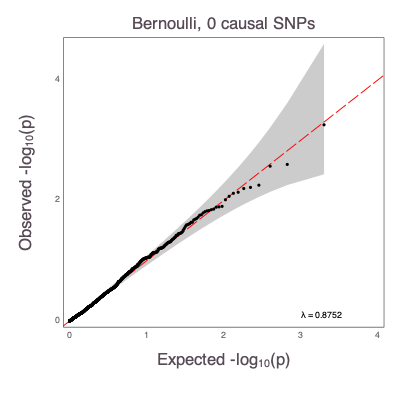

In [18]:
# Bernoulli
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [23]:
# autodiff Bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 15.632313 seconds (14.20 M allocations: 791.914 MiB, 1.08% gc time, 18.99% compilation time)


1000-element Vector{Float64}:
 0.24078721114520044
 0.9499464267776582
 0.7552663701620361
 0.12437754662832011
 0.9550289144105244
 0.37011726562375974
 0.9206511392712703
 0.058336768520394294
 0.6254059794421668
 0.20230092575615186
 0.7313318917627681
 0.3847447406534188
 0.05892959577255896
 ⋮
 0.4446337362982035
 0.7959005011215401
 0.2903783250666979
 0.4998894492062646
 0.450135641584682
 0.20934744993799695
 0.9394918471030926
 0.5211611159054544
 0.218456765429749
 0.7826741623311051
 0.16854076829713455
 0.5006870020144161

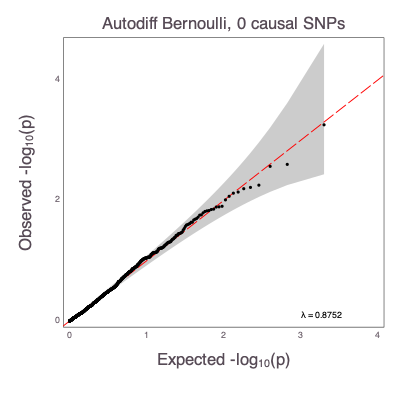

In [24]:
qq(pvals, dpi=80, titles="Autodiff Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))